In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
from scipy.optimize import curve_fit
from src.utils import find_ckpt_file

# Load Meta-RL results

In [3]:
corr = 0.25
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "darkroom_simple")
path_to_pkl = os.path.join(os.path.dirname(path_to_pkl), 'eval_results_offline.pkl')

epoch=13-val_loss=0.911523.ckpt


In [4]:
with open(path_to_pkl, "rb") as f:
    data = pickle.load(f)
metarl_df = pd.DataFrame(data)
metarl_df.head()

,model,return,environment,experienced_reward,context_length,path_length_scaled
0,Learner (temp=2),0.000000,0,0,0,1.000000
1,Learner (temp=1),0.000000,0,0,0,1.000000
2,Learner (greedy),0.000000,0,0,0,1.000000
3,Learner (temp=2),0.009091,0,0,10,0.990909
4,Learner (temp=1),0.014268,0,0,10,0.985732


# Include Q learning results

In [5]:
add_q_learning = True

In [6]:
# Concatenate the dataframes
if add_q_learning:
    engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
    wandb_project = "darkroom_qlearning"
    env_name = "darkroom_dim6_corr0.25_state_dim10_envs1500000_H250_explore"

    # DQN results
    model_name = "dqn_nlayers4_gamma0.9_target10_lr1e-05"
    path_to_pkl = os.path.join(engram_dir, wandb_project, env_name, "models", model_name, "eval_results.pkl")
    with open(path_to_pkl, "rb") as f:
        data = pickle.load(f)
    dqn_df = pd.DataFrame(data)
    dqn_df = dqn_df[dqn_df['action_temps'] == 0.005]
    dqn_df = dqn_df.rename(columns={'returns': 'return'})
    dqn_df['model'] = 'DQN'
    dqn_df['path_length_scaled'] = 1 - dqn_df['return']
    dqn_df['returns_scaled'] = dqn_df['return']

    # Q table results
    model_name = "q_table_gamma0.8"
    path_to_pkl = os.path.join(engram_dir, wandb_project, env_name, "models", model_name, "eval_results.pkl")
    with open(path_to_pkl, "rb") as f:
        data = pickle.load(f)
    qtable_df = pd.DataFrame(data)
    qtable_df = qtable_df[qtable_df['action_temps'] == 0.005]
    qtable_df = qtable_df.rename(columns={'returns': 'return'})
    qtable_df['model'] = 'Q Table'
    qtable_df['path_length_scaled'] = 1 - qtable_df['return']
    qtable_df['returns_scaled'] = qtable_df['return']
    qtable_df.head()

    df = pd.concat([metarl_df, dqn_df, qtable_df], ignore_index=True)
else:
    df = metarl_df


# Plot summary results

In [7]:
colors = ['C0', 'C4', 'C2']

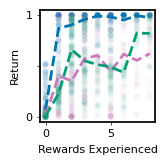

In [8]:
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

rlim = 9
_df = df[df['experienced_reward'] < rlim]

fig, ax = plt.subplots(figsize=(1.75, 1.75))
for model_idx, model in enumerate(["Learner (greedy)", "DQN", "Q Table",]):
    __df = _df[_df['model'] == model]
    alpha = 0.05
    sns.scatterplot(
        data=__df, x='experienced_reward', y='return',
        ax=ax, alpha=alpha, color=colors[model_idx], size=8)
    
    # Group by experienced_reward and get mean path_length_scaled
    x = __df['experienced_reward']
    y = __df['return']
    grouped = __df.groupby('experienced_reward')['return'].mean().reset_index()
    mean_x = grouped['experienced_reward']
    mean_y = grouped['return']
    ax.plot(mean_x, mean_y, '--', label=model, linewidth=2, color=colors[model_idx])
plt.xticks(fontsize=8)
plt.yticks([0, 0.5, 1], ['0', '', '1'], fontsize=8)
plt.xlabel('Rewards Experienced', fontsize=8)
plt.ylabel('Return', fontsize=8)
ax.get_legend().remove()
plt.tight_layout()
plt.savefig(f'figs/2b.png', transparent=True, dpi=300)
plt.savefig(f'figs/2b.svg', transparent=True, dpi=300)
plt.show()


# Plot individual trajectories

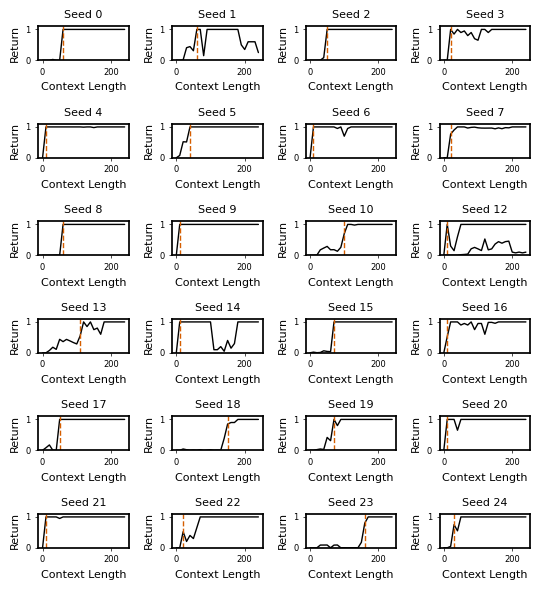

In [25]:
rlim = 30
_df = df[df['model'] == 'Learner (greedy)']
sample_envs = _df['environment'].unique()

# Create 3x4 subplot grid
n_rows = 6
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.5, 6))
axes = axes.flatten()
n_envs_plotted = 0
n_envs_total = n_rows * n_cols
for env in sample_envs:
    env_df = _df[_df['environment'] == env]
    # Find first context length where reward > 0
    first_reward = env_df[env_df['experienced_reward'] > 0]['context_length'].min()
    sns.lineplot(
        data=env_df,
        x='context_length',
        y='return',
        ax=axes[n_envs_plotted],
        linewidth=1.,
        color='black'
    )
    if pd.notna(first_reward) and first_reward < 1000:
        axes[n_envs_plotted].axvline(
            x=first_reward, color='r', linestyle='--', alpha=1.)
    else:
        continue
    axes[n_envs_plotted].set_title(f'Seed {env}', fontsize=8)
    axes[n_envs_plotted].set_xlabel('Context Length', fontsize=8)
    axes[n_envs_plotted].set_ylabel('Return', fontsize=8)
    axes[n_envs_plotted].set_ylim(0, max(1, env_df['return'].max()*1.1))
    axes[n_envs_plotted].set_yticks([0, 1])
    axes[n_envs_plotted].set_yticklabels(['0', '1'], fontsize=6)
    axes[n_envs_plotted].set_xticks([0, 200])
    axes[n_envs_plotted].set_xticklabels(['0', '200'], fontsize=6)

    n_envs_plotted += 1
    if n_envs_plotted == n_envs_total:
        break

plt.tight_layout()
plt.savefig(f'figs_app/D_12a.png', transparent=True, dpi=300)
plt.savefig(f'figs_app/D_12a.pdf', transparent=True, dpi=300)
plt.show()


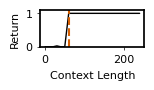

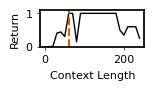

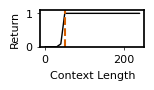

In [26]:
# Save each environment plot individually
fig_dir = 'figs/2a/'
os.makedirs(fig_dir, exist_ok=True)
rlim = 30
_df = df[df['model'] == 'Learner (greedy)']
sample_envs = _df['environment'].unique()

n_envs_saved = 0
for env in sample_envs:
    env_df = _df[_df['environment'] == env]
    # Find first context length where reward > 0
    first_reward = env_df[env_df['experienced_reward'] > 0]['context_length'].min()
    if pd.notna(first_reward) and first_reward < 200:
        pass
    else:
        continue
    fig, ax = plt.subplots(figsize=(1.75, 1.))
    sns.lineplot(
        data=env_df,
        x='context_length',
        y='return',
        ax=ax,
        linewidth=1.,
        color='black'
    )
    ax.axvline(x=first_reward, color='r', linestyle='--', alpha=1., linewidth=1.5)
    ax.set_xlabel('Context Length', fontsize=8)
    ax.set_ylabel('Return', fontsize=8)
    ax.set_ylim(0, max(1, env_df['return'].max()*1.1))
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'{fig_dir}/env{env}.png', transparent=True, dpi=300)
    plt.savefig(f'{fig_dir}/env{env}.svg', transparent=True, dpi=300)
    if n_envs_saved < 3:
        plt.show()
    plt.close()

    n_envs_saved += 1

